In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import joblib
import json

In [2]:
df = pd.read_csv("../data/insurance.csv")
df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.92400
1,18,male,33.77,1,no,southeast,1725.55230
2,28,male,33,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.88,0,no,northwest,3866.85520


In [3]:
df.describe()

,charges
count,1341.000000
mean,13900.419967
std,24067.747662
min,-55135.402090
25%,4687.797000
50%,9361.326800
75%,16776.304050
max,754428.887900


In [4]:
df.dtypes

age          object
sex          object
bmi          object
children     object
smoker       object
region       object
charges     float64
dtype: object

In [4]:
df.isna().sum()

age         0
sex         5
bmi         7
children    3
smoker      5
region      5
charges     5
dtype: int64

In [5]:
numeric_cols = ["age", "bmi", "children", "charges"]
for col in numeric_cols:
    df[col] = pd.to_numeric(df[col], errors = "coerce")

In [6]:
df.dtypes

age         float64
sex          object
bmi         float64
children    float64
smoker       object
region       object
charges     float64
dtype: object

In [7]:
df.isna().sum()

age         3
sex         5
bmi         9
children    6
smoker      5
region      5
charges     5
dtype: int64

In [8]:
# Normalize text columns: lowercase + strip spaces
cat_cols = ["sex", "smoker", "region"]
for col in cat_cols:
    df[col] = df[col].astype(str).str.lower().str.strip()

In [9]:
df["sex"].unique()

array(['female', 'male', 'nan'], dtype=object)

In [10]:
df["smoker"].unique()

array(['yes', 'no', 'nan', 'n', 'noo'], dtype=object)

In [11]:
# fix column smoker typos manually
df["smoker"] = df["smoker"].replace({
    "yes": "yes",
    "no": "no",
    "n": "no",
    "noo": "no"
})

In [12]:
df["smoker"].unique()

array(['yes', 'no', 'nan'], dtype=object)

In [13]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast', 'nan',
       'south east', 'north east', 'north west'], dtype=object)

In [14]:
df["region"] = df["region"].replace({
    "south east": "southeast",
    "north west": "northwest",
    "north east": "northeast"
})

In [15]:
df["region"].unique()

array(['southwest', 'southeast', 'northwest', 'northeast', 'nan'],
      dtype=object)

In [16]:
# Filling numeric missing values with median bcoz Median is robust (not affected by outliers).
for col in numeric_cols:
    df[col] = df[col].fillna(df[col].median())

In [17]:
# Fill categorical missing values (using mode)
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

In [18]:
# Checking missing values again
df.isna().sum()

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64

In [19]:
df.duplicated().sum()

np.int64(9)

In [20]:
df = df.drop_duplicates()

In [21]:
df.duplicated().sum()

np.int64(0)

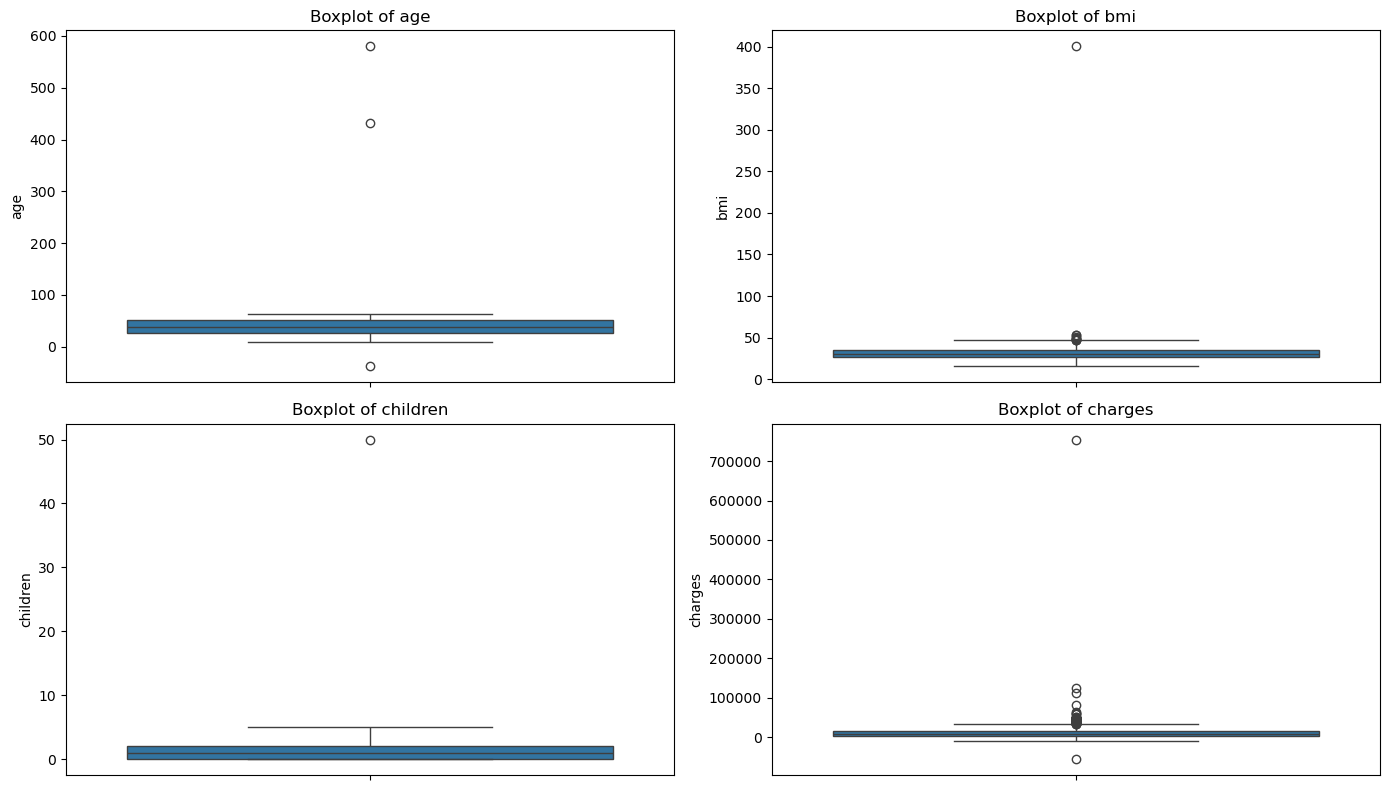

In [22]:
# Boxplot chart for numeric columns
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col}")
plt.tight_layout()
plt.show()

In [23]:
# Remove impossible ages
df = df[(df['age'] >= 0) & (df['age'] <= 120)]

# Remove impossible BMI
df = df[(df['bmi'] > 10) & (df['bmi'] < 90)]

# Remove unrealistic children count
df = df[df['children'] < 10]

# Remove negative charges
# Drop negative values AND drop all values above 600,000
high_threshold = 600000
df = df[(df['charges'] >= 0) & (df['charges'] < high_threshold)]

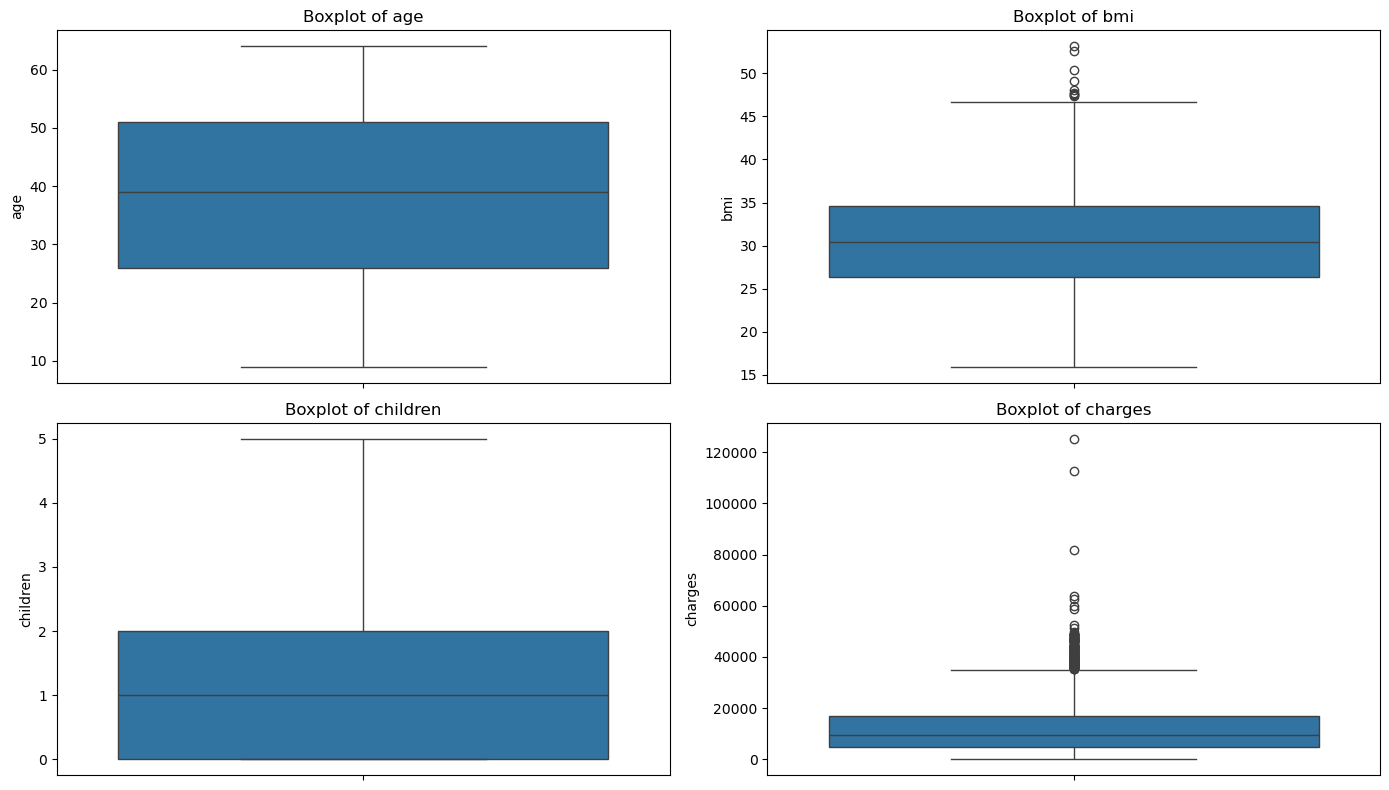

In [24]:
plt.figure(figsize=(14, 8))
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(2, 2, i)
    sns.boxplot(data=df, y=col)
    plt.title(f"Boxplot of {col}")

plt.tight_layout()

# Save BEFORE show
plt.savefig("../plots/Boxplot_numeric_columns.png", dpi=300)

plt.show()

In [25]:
df["charges"].skew()

np.float64(2.160496818061121)

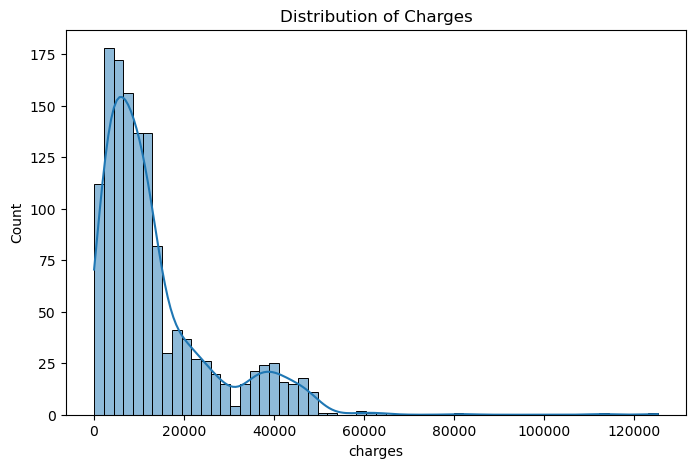

In [26]:
plt.figure(figsize=(8, 5))
sns.histplot(df['charges'], kde=True)
plt.title('Distribution of Charges')

# Save BEFORE show
plt.savefig("../plots/charges_distribution.png", dpi=300)

plt.show()

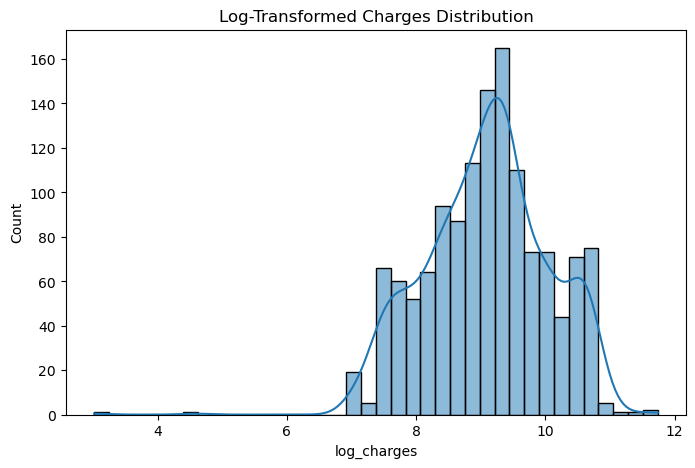

In [27]:
# Apply log transform
df['log_charges'] = np.log1p(df['charges'])

# Plot new distribution
plt.figure(figsize=(8, 5))
sns.histplot(df['log_charges'], kde=True)
plt.title("Log-Transformed Charges Distribution")

#plt.savefig("../plots/Log-Transformed_Charges.png", dpi=300)
plt.show()

In [28]:
df['log_charges'].skew()

np.float64(-0.3183341679306982)

In [29]:
df.head()

,age,sex,bmi,children,smoker,region,charges,log_charges
0,19.0,female,27.900,0.0,yes,southwest,16884.92400,9.734236
1,18.0,male,33.770,1.0,no,southeast,1725.55230,7.453882
2,28.0,male,33.000,3.0,no,southeast,4449.46200,8.400763
3,33.0,male,22.705,0.0,no,northwest,21984.47061,9.998137
4,32.0,male,28.880,0.0,no,northwest,3866.85520,8.260455


In [30]:
# Droping the original charges column Because from now on, model uses log_charges.
df = df.drop(columns=["charges"])

In [31]:
# Encoding categorical variables -> Using One-Hot Encoding because the categories are nominal:
df_encoded = pd.get_dummies(df, drop_first=True)

In [32]:
df_encoded.head()

,age,bmi,children,log_charges,sex_male,sex_nan,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19.0,27.900,0.0,9.734236,False,False,False,True,False,False,False,True
1,18.0,33.770,1.0,7.453882,True,False,True,False,False,False,True,False
2,28.0,33.000,3.0,8.400763,True,False,True,False,False,False,True,False
3,33.0,22.705,0.0,9.998137,True,False,True,False,False,True,False,False
4,32.0,28.880,0.0,8.260455,True,False,True,False,False,True,False,False


In [33]:
# sex_nan should NOT exist. 
# How to fix the issue
# STEP A — Replace literal string "nan" with actual NaN
df.replace("nan", np.nan, inplace=True)

# STEP B — Re-fill missing values in categorical columns
for col in cat_cols:
    df[col] = df[col].fillna(df[col].mode()[0])

# STEP C — Recreate encoding (fresh)
df_encoded = pd.get_dummies(df, drop_first=True)
cols = ["age", "children", "sex_male", "smoker_yes",
        "region_northwest", "region_southeast", "region_southwest"]

df_encoded[cols] = df_encoded[cols].astype(int)

In [34]:
df_encoded.head()

,age,bmi,children,log_charges,sex_male,smoker_yes,region_northwest,region_southeast,region_southwest
0,19,27.900,0,9.734236,0,1,0,0,1
1,18,33.770,1,7.453882,1,0,0,1,0
2,28,33.000,3,8.400763,1,0,0,1,0
3,33,22.705,0,9.998137,1,0,1,0,0
4,32,28.880,0,8.260455,1,0,1,0,0


In [35]:
# Define X and y
X = df_encoded.drop("log_charges", axis=1)
model_columns = list(X.columns)
with open("../models/columns.json", "w") as f:
    json.dump(model_columns, f)
y = df_encoded["log_charges"]
model_columns

['age',
 'bmi',
 'children',
 'sex_male',
 'smoker_yes',
 'region_northwest',
 'region_southeast',
 'region_southwest']

In [36]:
# Identify numeric columns to scale
num_cols = ["age", "bmi", "children"]

# Scale numeric features (StandardScaler)
scaler = StandardScaler()
X[num_cols] = scaler.fit_transform(X[num_cols])
joblib.dump(scaler, "../models/scaler.pkl")

['../models/scaler.pkl']

In [37]:
# Train/Test Split Using 80/20 split with a fixed random state:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

In [38]:
# Models
lin_reg = LinearRegression()
rf = RandomForestRegressor(random_state=42)
gboost = GradientBoostingRegressor(random_state=42)

# Train
lin_reg.fit(X_train, y_train)
rf.fit(X_train, y_train)
gboost.fit(X_train, y_train)

# Save each
joblib.dump(lin_reg, "../models/linear_regression.pkl")
joblib.dump(rf, "../models/random_forest.pkl")
joblib.dump(gboost, "../models/gradient_boosting.pkl")

['../models/gradient_boosting.pkl']

In [39]:
# Predict
lin_pred_log = lin_reg.predict(X_test)
rf_pred_log = rf.predict(X_test)
gb_pred_log = gboost.predict(X_test)

In [40]:
# converting back from log to real money
lin_pred = np.exp(lin_pred_log)
rf_pred = np.exp(rf_pred_log)
gb_pred = np.exp(gb_pred_log)

y_test_real = np.expm1(y_test)

In [41]:
# Evaluate the Regression. using RMSE and R² score
# rmse = mean_squared_error(y_test_real, y_pred_real, squared=False)
# r2 = r2_score(y_test_real, y_pred_real)
# rmse, r2


def evaluate(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    
    return mae, mse, rmse, r2

lin_metrics = evaluate(y_test_real, lin_pred)
rf_metrics  = evaluate(y_test_real, rf_pred)
gb_metrics  = evaluate(y_test_real, gb_pred)

print("Linear Regression:", lin_metrics)
print("Random Forest:", rf_metrics)
print("Gradient Boosting:", gb_metrics)

Linear Regression: (4114.338275340276, 63034283.84409833, np.float64(7939.413318633709), 0.6038936455272108)
Random Forest: (2284.459432805345, 22916069.599166065, np.float64(4787.073176708924), 0.8559958131638193)
Gradient Boosting: (2394.013953377118, 24788306.84583873, np.float64(4978.785679845913), 0.844230706538322)


In [42]:
results = pd.DataFrame([
    ["Linear Regression", *lin_metrics],
    ["Random Forest", *rf_metrics],
    ["Gradient Boosting", *gb_metrics]
], columns=["Model", "MAE", "MSE", "RMSE", "R2"])

results.to_csv("../results/model_performance.csv", index=False)

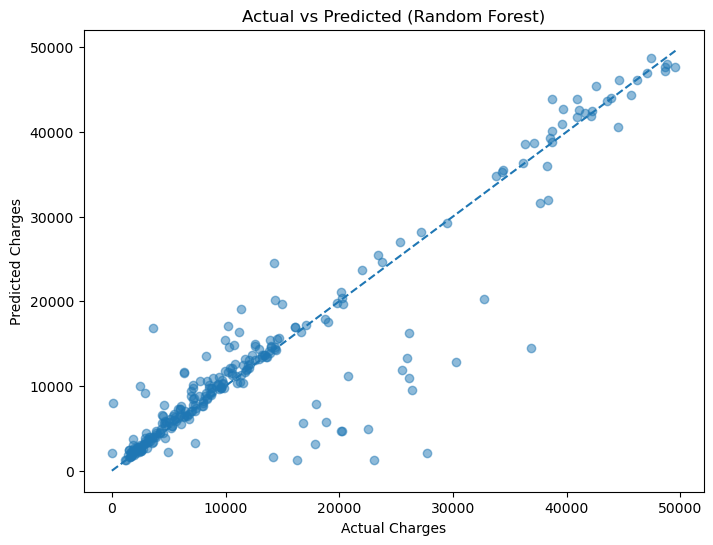

In [45]:
plt.figure(figsize=(8, 6))
plt.scatter(y_test_real, rf_pred, alpha=0.5)
plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")
plt.title("Actual vs Predicted (Random Forest)")
plt.plot([0, max(y_test_real)], [0, max(y_test_real)], "--")  # 45° line
plt.savefig("../plots/actual_vs_predicted_rf.png")
plt.show()

In [44]:
# Create a small table to compare
comparison = pd.DataFrame({
    'Actual Price': y_test_real,
    'Predicted Price': rf_metrics
})
print(comparison.head(20))

ValueError: array length 4 does not match index length 266

In [46]:
# Assuming rf is your trained Random Forest model
importances = rf.feature_importances_

# Feature names
feature_names = X_train.columns

# Create DataFrame
feat_importance = pd.DataFrame({
    "Feature": feature_names,
    "Importance": importances
}).sort_values(by="Importance", ascending=False)

feat_importance.head()

,Feature,Importance
4,smoker_yes,0.424789
0,age,0.395904
1,bmi,0.100676
2,children,0.040090
3,sex_male,0.013590


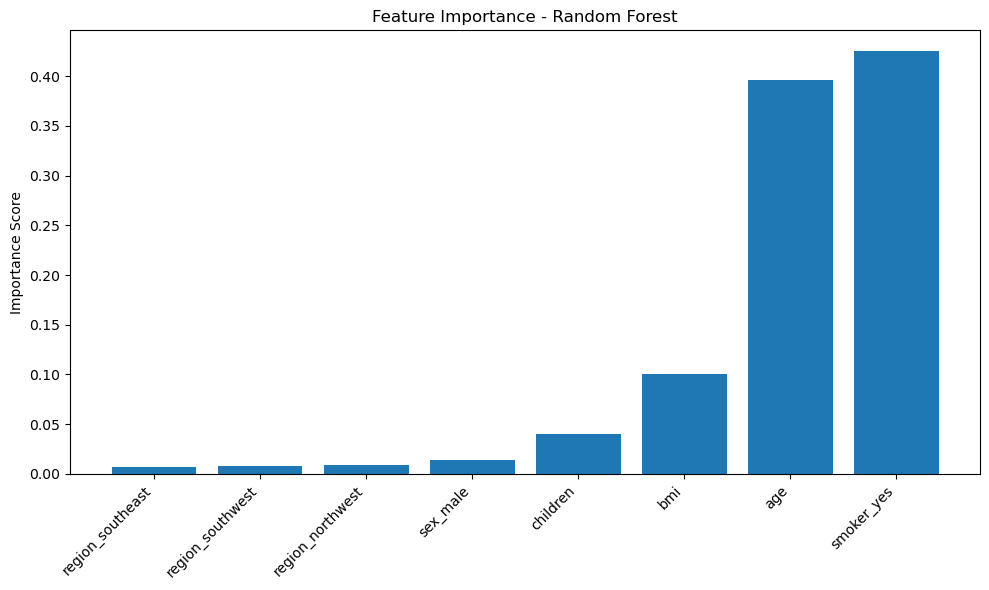

In [56]:
# 1. Sort the dataframe by 'Importance' in ascending order
feat_importance_sorted = feat_importance.sort_values(by="Importance", ascending=True)

plt.figure(figsize=(10, 6))

# 2. Plot using the sorted dataframe
plt.bar(feat_importance_sorted["Feature"], feat_importance_sorted["Importance"])

plt.ylabel("Importance Score")
plt.title("Feature Importance - Random Forest")
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig("../plots/feature_importance_random_forest.png", dpi=300)
plt.show()